<h4>
<ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">OBJECTIVE:</span></strong></li>
</ul>
<p><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Use the text data to build a deep-learning based binary classifier.</span></p>
    </h4>

In [1]:
# imports

import warnings
warnings.filterwarnings('ignore')

import os
import math
import random
from time import time
from pathlib import Path
import pandas as pd, numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict, Counter
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud, STOPWORDS
import tensorflow

tqdm.pandas()
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
# reproducibility
seed = 7
random.seed(seed)
tensorflow.random.set_seed(seed)

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Import the clean data.</span></strong></li>
</ul></h3>

In [3]:
dataset = pd.read_csv('./data/augmented_data.csv')
dataset.sample(10)

,Unnamed: 0,translated_description,keywords,short_description,description,group,cleaned_description,cleaned_short_description,merged_description,char_length,word_length,short_char_length,short_word_length,language,language_confidence,label
10802,2303,mm team need item related must replace the new...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4710,4710,error drue get message password change kindly ...,error drue get message password,error druing password change.,\n\nreceived from: fjnmxoya.iljgptas@gmail.com...,GRP_0,get message password change kindly help,error drue password change,error drue get message password change kindly ...,161.0,16.0,29.0,4.0,en,0.432568,0
6184,6184,password expire,password expire,password has expired,password has expired,GRP_0,password expire,password expire,password expire,20.0,3.0,20.0,3.0,en,0.448508,0
4565,4565,ticket update inplant,ticket update inplant,ticket update on inplant_859389,ticket update on inplant_859389,GRP_0,ticket update inplant,ticket update inplant,ticket update inplant,31.0,4.0,31.0,4.0,en,0.481380,0
11244,2745,Time error in the application of funding,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
6207,6207,dear help download software engineering tool e...,enterprise aurangabad maharashtra dist code,it help for engineering_tool and engineering_...,"dear sir,\n\nplease help to download software ...",GRP_0,dear help download software engineering tool e...,help engineer tool engineering tool,dear help download software engineering tool e...,248.0,41.0,50.0,6.0,en,0.697728,0
10175,1676,day advise if crm go update time number proble...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
10935,2436,response network resources work usually provid...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
546,546,scan t work home printer,scan t work home printer,scan doesn't work in the home printer,scan doesn't work in the home printer,GRP_0,scan t work home printer,scan t work home printer,scan t work home printer,37.0,7.0,37.0,7.0,en,0.723671,0
3959,3959,sfb issue ca t access skype business come mes...,office root office lync exe,sfb issue,can't access skype for business 2015\ncomes up...,GRP_0,ca t access skype business come message progr...,sfb issue,sfb issue ca t access skype business come mes...,124.0,15.0,10.0,2.0,en,0.602962,0


In [4]:
dataset.isna().sum()

Unnamed: 0                      0
translated_description          0
keywords                     4844
short_description            4834
description                  4834
group                        4834
cleaned_description          4891
cleaned_short_description    4884
merged_description           4834
char_length                  4834
word_length                  4834
short_char_length            4834
short_word_length            4834
language                     4834
language_confidence          4834
label                           0
dtype: int64

In [5]:
dataset.label.value_counts()

1    7348
0    5985
Name: label, dtype: int64

In [6]:
X = np.array(dataset.translated_description)
y = np.array(dataset.label)
X.shape, y.shape

((13333,), (13333,))

In [7]:
from tensorflow.keras.utils import to_categorical
y_dummy_coded = to_categorical(y)
y[0], y_dummy_coded[0]

(0, array([1., 0.], dtype=float32))

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_dummy_coded, test_size=.15,
                                                    random_state=seed, stratify=y_dummy_coded)  # splits are stratified by y

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11333,), (2000,), (11333, 2), (2000, 2))

In [10]:
X_train[0], y_train[0]  # check sample

('able print id', array([1., 0.], dtype=float32))

In [11]:
# TODO: Check the distributions of groups in training and testing sets, i.e, if they vary too much
# stratify by y if required during splits
# or data augmentation to upsample minority classes to balance the group distributions

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Tokenize and pad sequences</span></strong></li>
</ul></h3>

In [12]:
# define params
NUM_WORDS = 20000
EMBEDDING_DIM = 300
MAX_LEN = 100 # dataset['word_length'].max()
MAX_LEN

100

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(X_train)
X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)
X_train_tokens[0], X_test_tokens[0]

([84, 82, 1751],
 [2,
  7,
  44,
  8967,
  8968,
  8969,
  170,
  36,
  473,
  851,
  198,
  49,
  272,
  99,
  13,
  506,
  144,
  1517,
  292,
  1070,
  45,
  8970,
  5,
  6754,
  309,
  295,
  362,
  888,
  1075,
  112,
  2359,
  3150,
  435,
  215,
  8971,
  2060,
  191,
  481,
  77,
  1146,
  413,
  185,
  6,
  245,
  390,
  2086,
  900,
  215,
  1311,
  53,
  105,
  100,
  1455,
  1279,
  1147,
  1828,
  1091,
  163,
  247,
  987,
  124,
  47,
  97,
  599,
  193,
  232,
  300,
  22,
  43,
  332,
  160,
  644,
  221,
  139,
  550,
  672,
  699,
  1827,
  725,
  426,
  133,
  157,
  8972,
  8973,
  8974,
  312,
  869,
  428,
  105,
  1440,
  163,
  497,
  129,
  206,
  8975,
  101,
  423,
  48,
  403,
  8976,
  8977,
  163,
  458,
  434,
  3749,
  1488,
  8978,
  322,
  4815,
  375,
  191,
  3253,
  142,
  127,
  60,
  59,
  37,
  53,
  239,
  474,
  1109,
  371,
  826,
  132,
  135,
  477,
  24,
  142,
  53,
  105,
  570,
  142,
  8979,
  134,
  2618,
  1384,
  857,
  348,
  105,


In [14]:
y_train[0], y_test[0]

(array([1., 0.], dtype=float32), array([1., 0.], dtype=float32))

In [15]:
# pad sequences to cut longer texts to a uniform length and pad the sentences that are shorter than that with <PAD> token

# using just 20 words from each headline will severely limit the information that is 
# available to the model and affect performance although the training will be faster
X_train_padded = pad_sequences(X_train_tokens,
                               padding='post',
                               truncating='post',
                               maxlen=MAX_LEN)
X_test_padded = pad_sequences(X_test_tokens,
                              padding='post',
                              truncating='post',
                              maxlen=MAX_LEN)


print(f'X train:  {X_train_padded.shape}\nX test:   {X_test_padded.shape}')

X train:  (11333, 100)
X test:   (2000, 100)


In [16]:
pprint(X_train_padded[0], compact=True)

array([  84,   82, 1751,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0])


In [17]:
WORD_TO_INDEX = tokenizer.word_index
# pprint(WORD_TO_INDEX, compact=True)
pprint(list(WORD_TO_INDEX.keys())[:100], compact=True)

['u', 'security', 'work', 'job', 'company', 'ts', 'system', 'password', 'tool',
 'the', 'yes', 'erp', 'user', 'na', 'error', 'sid', 'reset', 'access', 'issue',
 'need', 'to', 'ticket', 'v', 'use', 'problem', 'help', 'account', 'm', 'of',
 'email', 'get', 'fail', 'scheduler', 'hostname', 'unable', 'germany',
 'message', 'order', 'change', 'site', 'check', 'new', 'phone', 'name', 'see',
 'plant', 'login', 'network', 'update', 'time', 'printer', 'power', 'server',
 'create', 'circuit', 'ua', 'and', 'no', 'request', 'send', 'contact', 'report',
 'show', 'try', 'crm', 'streaming', 'type', 'with', 'start', 'outlook', 'is',
 'ucc', 'open', 't', 'backup', 'log', 'call', 'vendor', 'number', 'file',
 'engineering', 'print', 'management', 'able', 'pc', 'he', 'view', 'team',
 'receive', 'attach', 'delivery', 'telecom', 'not', 'connect', 'sped', 'could',
 'failure', 'customer', 'sale', 'also']


In [18]:
VOCAB_SIZE = len(WORD_TO_INDEX) + 1
VOCAB_SIZE

11025

In [19]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
def retrieve_description_feat(x, mapping=WORD_TO_INDEX) -> str:
    # increment 3 
    mapping = {k:(v + 3) for k, v in mapping.items()}
    mapping['<PAD>'] = 0
    mapping['<START>'] = 1
    mapping['<UNK>'] = 2
    inv_mapping = {v: k for k, v in mapping.items()}
    return str(" ".join(inv_mapping.get(i, '<NA>') for i in x))

retrieve_description_feat(X_test_padded[7])

'site gtc misadjust hrt time laptop is environment dose work erp hostname not v <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>'

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">GloVe Embeddings</span></strong></li>
</ul></h3>

In [20]:
EMBEDDING_DIM

300

In [21]:
def get_embedding_matrix(embedding_dim=EMBEDDING_DIM):
    embeddings = defaultdict()
    if embedding_dim == 200:
        file_path = f'./data/glove.6B.{embedding_dim}d.txt'
    elif embedding_dim == 300:
        file_path = f'./data/glove.840B.{embedding_dim}d.txt'
    for l in open(file_path, encoding='utf-8'):
        word = l.split(" ")[0]
        embeddings[word] = np.asarray(l.split(" ")[1:], dtype='float32')

    embeddings = dict(embeddings)

    # create a weight matrix for words in training docs
    embedding_matrix = np.zeros((NUM_WORDS, embedding_dim))

    for word, idx in WORD_TO_INDEX.items():
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [22]:
# use pre-trained glove embedding matrix to initialize weights in our model
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(20000, 300)

<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Simple Feed-Forward Neural Net</span></strong></li>
</ul></h4>

In [23]:
# !pip install livelossplot
from tensorflow.python.keras.models import Sequential
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm, unit_norm
from tensorflow.python.keras.callbacks import LambdaCallback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Flatten, Dense, Activation, BatchNormalization, Dropout, Embedding, LSTM, MaxPooling1D, Conv1D, Bidirectional

In [24]:
NUM_CLASSES = 2
VOCAB_SIZE, MAX_LEN, EMBEDDING_DIM, NUM_CLASSES

(11025, 100, 300, 2)

In [25]:
# define model

model1 = Sequential([ 
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    Flatten(),
    Dense(1024, activation = 'relu'),
    Dense(1024, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(NUM_CLASSES, activation = 'softmax')
])

model1.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [26]:
# Define Callbacks and a few helper functions

# simplify the training log
simple_log = LambdaCallback(
    on_epoch_end = lambda e, l: print(f" ~| Epoch: {e+1} | Validation Loss: {l['val_loss']:.5f}", end =" >|> \n" ))

# early stopping
early_stop = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=7,
                              verbose=0, 
                              restore_best_weights=True)

# learning rate reduction
lr_reduce_on_plateau = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.4,
                                            min_lr=0.00001)

def plot_learning_curve(hist):
    sns.set()
    plt.figure(figsize=(5,5))
    train = hist.history['loss']
    val = hist.history['val_loss']
    epochs_run = range(1,len(train) + 1)
    sns.lineplot(epochs_run, train, marker = 'o', color = 'coral', label = 'Training Loss')
    sns.lineplot(epochs_run, val,  marker = '>', color = 'green', label = 'Validation Loss')
    plt.title("Loss vs. Epochs", fontsize = 20)
    plt.legend()
    plt.show()

In [27]:
X_train[0]

'able print id'

In [28]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((11333,), (11333, 2), (2000,), (2000, 2))

In [29]:
EPOCHS = 200
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h1 = model1.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop],
            verbose = False)
except Exception as e:
    print(e)
    print("\nTraining on CPU:")
    h1 = model1.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.28871 >|> 
 ~| Epoch: 2 | Validation Loss: 0.38565 >|> 
 ~| Epoch: 3 | Validation Loss: 0.30709 >|> 
 ~| Epoch: 4 | Validation Loss: 0.53097 >|> 
 ~| Epoch: 5 | Validation Loss: 0.56701 >|> 
 ~| Epoch: 6 | Validation Loss: 0.58290 >|> 
 ~| Epoch: 7 | Validation Loss: 0.65256 >|> 
 ~| Epoch: 8 | Validation Loss: 0.74256 >|> 

Training Done.


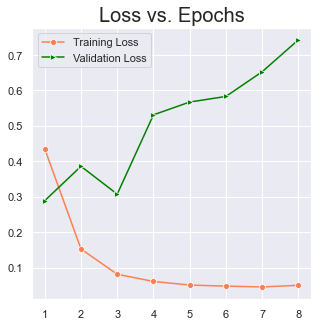

In [30]:
plot_learning_curve(h1)

In [31]:
loss, acc = model1.evaluate(X_test_padded, y_test)
print("Testing Loss: ", loss*100)
print("Testing Accuracy: ", acc*100)

63/63 [==============================] - 1s 14ms/step - loss: 0.2770 - accuracy: 0.8875 0s - loss: 0.2738 - accuracy: 
Testing Loss:  27.701136469841003
Testing Accuracy:  88.7499988079071


<h4><ul>
<span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">
    <li>This model is clearly overfitting, we will add regularization to the next iteration
 </span></ul></h4>

<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Simple Feed-Forward Neural Net + Batch Normalization</span></strong></li>
</ul></h4>

In [32]:
# define model

model2 = Sequential([ 
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    Flatten(),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dense(NUM_CLASSES, activation = 'softmax')
])

model2.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [33]:
EPOCHS = 200
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h2 = model2.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop],
            verbose = False)
except Exception as e:
    print(e)
    print("Training on CPU:")
    h2 = model2.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.40130 >|> 
 ~| Epoch: 2 | Validation Loss: 0.45292 >|> 
 ~| Epoch: 3 | Validation Loss: 0.84659 >|> 
 ~| Epoch: 4 | Validation Loss: 0.60096 >|> 
 ~| Epoch: 5 | Validation Loss: 0.42526 >|> 
 ~| Epoch: 6 | Validation Loss: 0.49044 >|> 
 ~| Epoch: 7 | Validation Loss: 0.99325 >|> 
 ~| Epoch: 8 | Validation Loss: 0.60758 >|> 

Training Done.


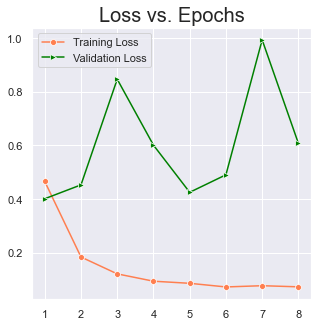

In [34]:
plot_learning_curve(h2)

In [35]:
loss, acc = model2.evaluate(X_test_padded, y_test)
print("Testing Loss: ", loss*100)
print("Testing Accuracy: ", acc*100)

63/63 [==============================] - 1s 15ms/step - loss: 0.3931 - accuracy: 0.8215
Testing Loss:  39.308100938797
Testing Accuracy:  82.15000033378601


<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Simple Feed-Forward Neural Net + Dropout</span></strong></li>
</ul></h4>

In [36]:
# define model

model3 = Sequential([ 
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    Flatten(),
    Dense(20, activation = 'relu'),
    Dropout(0.4),
    Dense(NUM_CLASSES, activation = 'softmax')
])

model3.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [37]:
EPOCHS = 200
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h3 = model3.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop, lr_reduce_on_plateau],
            verbose = False)
except Exception as e:
    print(e)
    print("Training on CPU:")
    h3 = model3.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop, lr_reduce_on_plateau],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.30426 >|> 
 ~| Epoch: 2 | Validation Loss: 0.29696 >|> 
 ~| Epoch: 3 | Validation Loss: 0.32437 >|> 
 ~| Epoch: 4 | Validation Loss: 0.37056 >|> 
 ~| Epoch: 5 | Validation Loss: 0.40950 >|> 
 ~| Epoch: 6 | Validation Loss: 0.47410 >|> 

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
 ~| Epoch: 7 | Validation Loss: 0.49842 >|> 
 ~| Epoch: 8 | Validation Loss: 0.50969 >|> 
 ~| Epoch: 9 | Validation Loss: 0.52093 >|> 

Training Done.


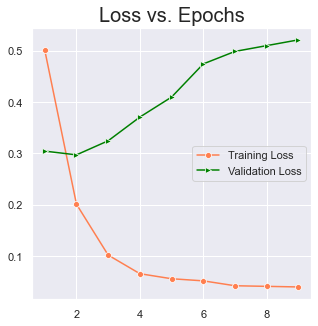

In [38]:
plot_learning_curve(h3)

In [39]:
loss, acc = model3.evaluate(X_test_padded, y_test)
print("Testing Accuracy: ", acc*100)

63/63 [==============================] - 1s 13ms/step - loss: 0.2609 - accuracy: 0.8865
Testing Accuracy:  88.65000009536743


<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Use pre-trained embeddings</span></strong></li>
</ul></h4>

In [40]:
# define model

model3 = Sequential([ 
    Embedding(input_dim=NUM_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN, weights=[embedding_matrix], trainable=True),
    Flatten(),
    Dense(30, activation = 'relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation = 'softmax')
])

model3.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'rmsprop',
    metrics = ['accuracy']
)

In [41]:
EPOCHS = 200
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h3 = model3.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop],
            verbose = False)
except Exception as e:
    print(e)
    print("Training on CPU:")
    h3 = model3.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.39525 >|> 
 ~| Epoch: 2 | Validation Loss: 0.37168 >|> 
 ~| Epoch: 3 | Validation Loss: 0.34597 >|> 
 ~| Epoch: 4 | Validation Loss: 0.36743 >|> 
 ~| Epoch: 5 | Validation Loss: 0.42770 >|> 
 ~| Epoch: 6 | Validation Loss: 0.59888 >|> 
 ~| Epoch: 7 | Validation Loss: 0.53574 >|> 
 ~| Epoch: 8 | Validation Loss: 0.67249 >|> 
 ~| Epoch: 9 | Validation Loss: 0.70937 >|> 
 ~| Epoch: 10 | Validation Loss: 0.69097 >|> 

Training Done.


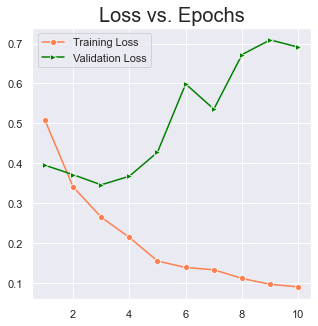

In [42]:
plot_learning_curve(h3)

In [43]:
loss, acc = model3.evaluate(X_test_padded, y_test)
print("Testing Accuracy: ", acc*100)

63/63 [==============================] - 1s 14ms/step - loss: 0.3330 - accuracy: 0.8730
Testing Accuracy:  87.30000257492065


<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">LSTM</span></strong></li>
</ul></h4>

In [44]:
# define model

model4 = Sequential([ 
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    LSTM(32),
    Dropout(0.4),
    Dense(NUM_CLASSES, activation = 'softmax')
])

model4.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [45]:
EPOCHS = 50
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h4 = model4.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, lr_reduce_on_plateau],
            verbose = False)
except Exception as e:
    print(e)
    print("Training on CPU:")
    h4 = model4.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, lr_reduce_on_plateau],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.67907 >|> 
 ~| Epoch: 2 | Validation Loss: 0.68206 >|> 
 ~| Epoch: 3 | Validation Loss: 0.68100 >|> 
 ~| Epoch: 4 | Validation Loss: 0.67827 >|> 
 ~| Epoch: 5 | Validation Loss: 0.68315 >|> 
 ~| Epoch: 6 | Validation Loss: 0.68224 >|> 
 ~| Epoch: 7 | Validation Loss: 0.50883 >|> 
 ~| Epoch: 8 | Validation Loss: 0.44830 >|> 
 ~| Epoch: 9 | Validation Loss: 0.59832 >|> 
 ~| Epoch: 10 | Validation Loss: 0.53059 >|> 
 ~| Epoch: 11 | Validation Loss: 0.42760 >|> 
 ~| Epoch: 12 | Validation Loss: 0.40717 >|> 
 ~| Epoch: 13 | Validation Loss: 0.42052 >|> 
 ~| Epoch: 14 | Validation Loss: 0.39164 >|> 
 ~| Epoch: 15 | Validation Loss: 0.38522 >|> 
 ~| Epoch: 16 | Validation Loss: 0.41581 >|> 
 ~| Epoch: 17 | Validation Loss: 0.45899 >|> 
 ~| Epoch: 18 | Validation Loss: 0.43926 >|> 
 ~| Epoch: 19 | Validation Loss: 0.45727 >|> 

Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
 ~| Epoch: 20 | Validation Loss: 0.49

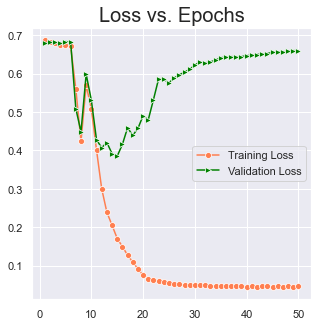

In [46]:
plot_learning_curve(h4)

In [47]:
loss, acc = model4.evaluate(X_test_padded, y_test)
print("Testing Accuracy: ", acc*100)

63/63 [==============================] - 2s 24ms/step - loss: 0.6078 - accuracy: 0.8820
Testing Accuracy:  88.20000290870667


<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Bi-Directional LSTM</span></strong></li>
</ul></h4>

In [48]:
# define model

model4 = Sequential([ 
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    Bidirectional(LSTM(32)),
    Dropout(0.4),
    Dense(NUM_CLASSES, activation = 'softmax')
])

model4.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'rmsprop',
    metrics = ['accuracy']
)

In [49]:
EPOCHS = 200
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h4 = model4.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop, lr_reduce_on_plateau],
            verbose = False)
except Exception as e:
    print(e)
    print("Training on CPU:")
    h4 = model4.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop, lr_reduce_on_plateau],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.33180 >|> 
 ~| Epoch: 2 | Validation Loss: 0.32196 >|> 
 ~| Epoch: 3 | Validation Loss: 0.30993 >|> 
 ~| Epoch: 4 | Validation Loss: 0.28978 >|> 
 ~| Epoch: 5 | Validation Loss: 0.29807 >|> 
 ~| Epoch: 6 | Validation Loss: 0.29704 >|> 
 ~| Epoch: 7 | Validation Loss: 0.32313 >|> 
 ~| Epoch: 8 | Validation Loss: 0.31997 >|> 

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
 ~| Epoch: 9 | Validation Loss: 0.34488 >|> 
 ~| Epoch: 10 | Validation Loss: 0.36579 >|> 
 ~| Epoch: 11 | Validation Loss: 0.36719 >|> 

Training Done.


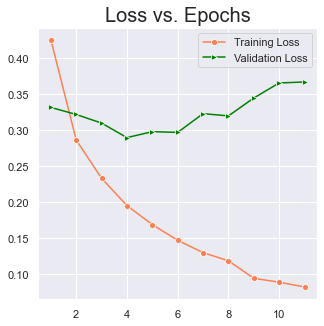

In [50]:
plot_learning_curve(h4)

In [51]:
loss, acc = model4.evaluate(X_test_padded, y_test)
print("Testing Accuracy: ", acc*100)

63/63 [==============================] - 2s 38ms/step - loss: 0.3001 - accuracy: 0.8815
Testing Accuracy:  88.15000057220459


<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">CNN (Dimensionality Reduction) + LSTM</span></strong></li>
</ul></h4>

In [52]:
model5 = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=256, input_length=MAX_LEN),
    Dropout(0.25),
    Conv1D(256, 5, padding = 'same', activation = 'relu', strides = 1),
    Conv1D(256, 5, padding = 'same', activation = 'relu', strides = 1),
    MaxPooling1D(pool_size = 2),
    Conv1D(64, 5, padding = 'same', activation = 'relu', strides = 1),
    MaxPooling1D(pool_size = 2),
    LSTM(75),
    Dense(NUM_CLASSES, activation = 'softmax')
])

model5.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [53]:
EPOCHS = 20
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h5 = model5.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop, lr_reduce_on_plateau],
            verbose = False)
except Exception as e:
    print(e)
    print("Training on CPU:")
    h5 = model5.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop, lr_reduce_on_plateau],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.34188 >|> 
 ~| Epoch: 2 | Validation Loss: 0.35376 >|> 
 ~| Epoch: 3 | Validation Loss: 0.30676 >|> 
 ~| Epoch: 4 | Validation Loss: 0.37361 >|> 
 ~| Epoch: 5 | Validation Loss: 0.40016 >|> 
 ~| Epoch: 6 | Validation Loss: 0.41424 >|> 
 ~| Epoch: 7 | Validation Loss: 0.44908 >|> 

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
 ~| Epoch: 8 | Validation Loss: 0.47460 >|> 
 ~| Epoch: 9 | Validation Loss: 0.47277 >|> 
 ~| Epoch: 10 | Validation Loss: 0.46540 >|> 

Training Done.


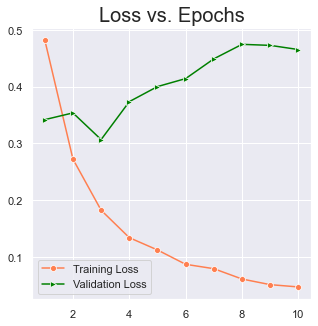

In [54]:
plot_learning_curve(h5)

In [55]:
loss, acc = model5.evaluate(X_test_padded, y_test)
print("Testing Accuracy: ", acc*100)

63/63 [==============================] - 1s 22ms/step - loss: 0.3071 - accuracy: 0.8710
Testing Accuracy:  87.09999918937683


<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">CNN (Dimensionality Reduction) + Bi-Directional LSTM</span></strong></li>
</ul></h4>

In [56]:
model5 = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=256, input_length=MAX_LEN),
    Dropout(0.25),
    Conv1D(256, 5, padding = 'same', activation = 'relu', strides = 1),
    Conv1D(256, 5, padding = 'same', activation = 'relu', strides = 1),
    MaxPooling1D(pool_size = 2),
    Conv1D(64, 5, padding = 'same', activation = 'relu', strides = 1),
    MaxPooling1D(pool_size = 2),
    Bidirectional(LSTM(75, recurrent_dropout=0.5)),
    Dense(NUM_CLASSES, activation = 'softmax')
])

model5.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [57]:
EPOCHS = 20
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h5 = model5.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop],
            verbose = False)
except Exception as e:
    print(e)
    print("Training on CPU:")
    h5 = model5.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.31797 >|> 
 ~| Epoch: 2 | Validation Loss: 0.32389 >|> 
 ~| Epoch: 3 | Validation Loss: 0.30010 >|> 
 ~| Epoch: 4 | Validation Loss: 0.32227 >|> 
 ~| Epoch: 5 | Validation Loss: 0.40878 >|> 
 ~| Epoch: 6 | Validation Loss: 0.44978 >|> 
 ~| Epoch: 7 | Validation Loss: 0.47793 >|> 
 ~| Epoch: 8 | Validation Loss: 0.52291 >|> 
 ~| Epoch: 9 | Validation Loss: 0.52136 >|> 
 ~| Epoch: 10 | Validation Loss: 0.52282 >|> 

Training Done.


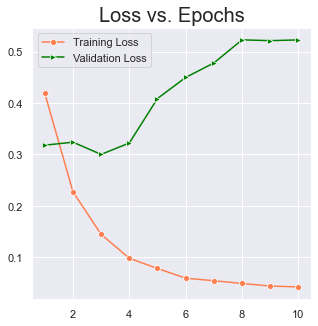

In [58]:
plot_learning_curve(h5)

In [59]:
loss, acc = model5.evaluate(X_test_padded, y_test)
print("Testing Accuracy: ", acc*100)

63/63 [==============================] - 9s 141ms/step - loss: 0.2836 - accuracy: 0.8930
Testing Accuracy:  89.30000066757202


<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Use TfIdf vectors instead of Embedding Layer + Feature Selection</span></strong></li>
</ul></h4>

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# using 75-25 split instead of 50-50 split as we need more data to train neural nets
X_train_vec, X_test_vec, y_train_vec, y_test_vec = train_test_split(X, y, test_size=0.15, random_state=seed, stratify=y)
print(f"Train dataset shape: {X_train_vec.shape}, \nTest dataset shape: {X_test_vec.shape}")

Train dataset shape: (11333,), 
Test dataset shape: (2000,)


In [61]:
NGRAM_RANGE = (1, 3)
TOP_K = 8500
TOKEN_MODE = 'word'
MIN_DOC_FREQ = 2


kwargs = {
    'ngram_range' : NGRAM_RANGE,
    'dtype' : 'int32',
    'strip_accents' : 'unicode',
    'decode_error' : 'replace',
    'analyzer' : TOKEN_MODE,
    'min_df' : MIN_DOC_FREQ
}
vectorizer = TfidfVectorizer(**kwargs)
X_train_vec = vectorizer.fit_transform(X_train_vec)
X_test_vec = vectorizer.transform(X_test_vec)
print(f"Train dataset shape: {X_train_vec.shape}, \nTest dataset shape: {X_test_vec.shape}")

Train dataset shape: (11333, 72499), 
Test dataset shape: (2000, 72499)


In [62]:
from sklearn.feature_selection import SelectKBest, f_classif

# Select best k features, with feature importance measured by f_classif
# Set k as 20000 or (if number of ngrams is less) number of ngrams   
selector = SelectKBest(f_classif, k=min(TOP_K, X_train_vec.shape[1]))
selector.fit(X_train_vec, y_train_vec)
X_train_vec = selector.transform(X_train_vec).astype('float32')
X_test_vec = selector.transform(X_test_vec).astype('float32')
X_train_vec = X_train_vec.toarray()
X_test_vec = X_test_vec.toarray()

print(f"Train dataset shape: {X_train_vec.shape}, \nTest dataset shape: {X_test_vec.shape}")

Train dataset shape: (11333, 8500), 
Test dataset shape: (2000, 8500)


In [63]:
model6 = Sequential([
    Dense(30, activation='relu', input_shape=X_train_vec.shape[1:]),
    Dropout(0.5),
    Dense(20, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model6.compile(
    loss = 'binary_crossentropy',
    optimizer = 'rmsprop',
    metrics = ['accuracy']
)

In [64]:
EPOCHS = 20
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h6 = model6.fit(
            X_train_vec, y_train_vec,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop],
            verbose = False)
except Exception:
    print("Training on CPU:")
    h6 = model6.fit(
            X_train_vec, y_train_vec,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.49508 >|> 
 ~| Epoch: 2 | Validation Loss: 0.35265 >|> 
 ~| Epoch: 3 | Validation Loss: 0.32318 >|> 
 ~| Epoch: 4 | Validation Loss: 0.31121 >|> 
 ~| Epoch: 5 | Validation Loss: 0.31545 >|> 
 ~| Epoch: 6 | Validation Loss: 0.30794 >|> 
 ~| Epoch: 7 | Validation Loss: 0.30748 >|> 
 ~| Epoch: 8 | Validation Loss: 0.30328 >|> 
 ~| Epoch: 9 | Validation Loss: 0.30813 >|> 
 ~| Epoch: 10 | Validation Loss: 0.30898 >|> 
 ~| Epoch: 11 | Validation Loss: 0.30375 >|> 
 ~| Epoch: 12 | Validation Loss: 0.30877 >|> 
 ~| Epoch: 13 | Validation Loss: 0.30750 >|> 
 ~| Epoch: 14 | Validation Loss: 0.31066 >|> 
 ~| Epoch: 15 | Validation Loss: 0.31174 >|> 

Training Done.


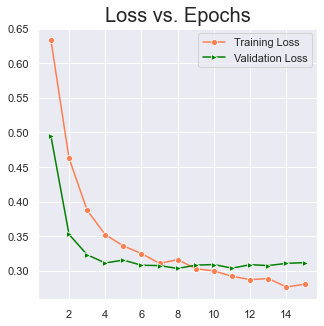

In [65]:
plot_learning_curve(h6)

In [66]:
loss, acc = model6.evaluate(X_test_vec, y_test_vec)
print("Testing Accuracy: ", acc*100)

63/63 [==============================] - 1s 12ms/step - loss: 0.3176 - accuracy: 0.8775
Testing Accuracy:  87.74999976158142


<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Use TfIdf vectors instead of Embedding Layer + Feature Selection + Stratified KFold Training</span></strong></li>
</ul></h4>


Train dataset shape: (12799, 44168), 
Test dataset shape: (534, 44168)

Features Train dataset shape: (12799, 15000), 
FeaturesTest dataset shape: (534, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.81273, saving model to models\binary_classfiier\dl\merged_descr\model_1.h5

Epoch 00002: val_accuracy improved from 0.81273 to 0.84270, saving model to models\binary_classfiier\dl\merged_descr\model_1.h5

Epoch 00003: val_accuracy did not improve from 0.84270

Epoch 00004: val_accuracy did not improve from 0.84270

Epoch 00005: val_accuracy did not improve from 0.84270

Epoch 00006: val_accuracy did not improve from 0.84270

Epoch 00007: val_accuracy did not improve from 0.84270

Epoch 00008: val_accuracy did not improve from 0.84270

Epoch 00009: val_accuracy did not improve from 0.84270


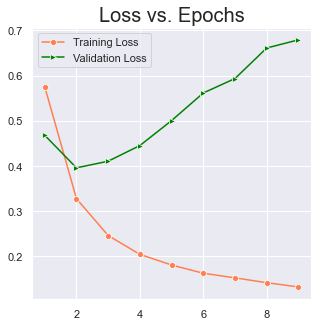

17/17 [==============================] - 0s 13ms/step - loss: 0.3959 - accuracy: 0.8427
Testing Accuracy:  84.26966071128845

Train dataset shape: (12799, 44121), 
Test dataset shape: (534, 44121)

Features Train dataset shape: (12799, 15000), 
FeaturesTest dataset shape: (534, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.79963, saving model to models\binary_classfiier\dl\merged_descr\model_2.h5

Epoch 00002: val_accuracy improved from 0.79963 to 0.82022, saving model to models\binary_classfiier\dl\merged_descr\model_2.h5

Epoch 00003: val_accuracy did not improve from 0.82022

Epoch 00004: val_accuracy improved from 0.82022 to 0.83895, saving model to models\binary_classfiier\dl\merged_descr\model_2.h5

Epoch 00005: val_accuracy did not improve from 0.83895

Epoch 00006: val_accuracy did not improve from 0.83895

Epoch 00007: val_accuracy did not improve from 0.83895

Epoch 00008: val_accuracy did not improve from 0.83895

Epoch 00009: val_accuracy did not improve from 0.

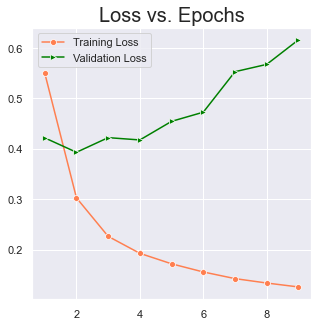

17/17 [==============================] - 0s 12ms/step - loss: 0.4175 - accuracy: 0.8390
Testing Accuracy:  83.89512896537781

Train dataset shape: (12799, 44130), 
Test dataset shape: (534, 44130)

Features Train dataset shape: (12799, 15000), 
FeaturesTest dataset shape: (534, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.76779, saving model to models\binary_classfiier\dl\merged_descr\model_3.h5

Epoch 00002: val_accuracy improved from 0.76779 to 0.79401, saving model to models\binary_classfiier\dl\merged_descr\model_3.h5

Epoch 00003: val_accuracy did not improve from 0.79401

Epoch 00004: val_accuracy did not improve from 0.79401

Epoch 00005: val_accuracy did not improve from 0.79401

Epoch 00006: val_accuracy did not improve from 0.79401

Epoch 00007: val_accuracy did not improve from 0.79401

Epoch 00008: val_accuracy did not improve from 0.79401

Epoch 00009: val_accuracy did not improve from 0.79401


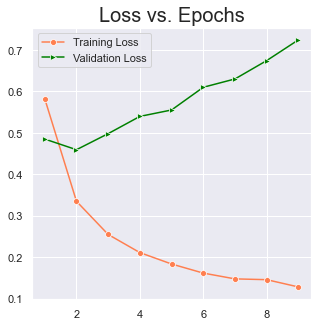

17/17 [==============================] - 0s 12ms/step - loss: 0.4594 - accuracy: 0.7940
Testing Accuracy:  79.40074801445007

Train dataset shape: (12799, 43700), 
Test dataset shape: (534, 43700)

Features Train dataset shape: (12799, 15000), 
FeaturesTest dataset shape: (534, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.79588, saving model to models\binary_classfiier\dl\merged_descr\model_4.h5

Epoch 00002: val_accuracy improved from 0.79588 to 0.79963, saving model to models\binary_classfiier\dl\merged_descr\model_4.h5

Epoch 00003: val_accuracy improved from 0.79963 to 0.80337, saving model to models\binary_classfiier\dl\merged_descr\model_4.h5

Epoch 00004: val_accuracy did not improve from 0.80337

Epoch 00005: val_accuracy did not improve from 0.80337

Epoch 00006: val_accuracy improved from 0.80337 to 0.80899, saving model to models\binary_classfiier\dl\merged_descr\model_4.h5

Epoch 00007: val_accuracy improved from 0.80899 to 0.81461, saving model to models\binar

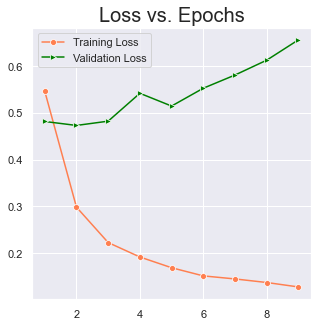

17/17 [==============================] - 0s 13ms/step - loss: 0.6120 - accuracy: 0.8184
Testing Accuracy:  81.83520436286926

Train dataset shape: (12799, 44148), 
Test dataset shape: (534, 44148)

Features Train dataset shape: (12799, 15000), 
FeaturesTest dataset shape: (534, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.82210, saving model to models\binary_classfiier\dl\merged_descr\model_5.h5

Epoch 00002: val_accuracy did not improve from 0.82210

Epoch 00003: val_accuracy improved from 0.82210 to 0.82397, saving model to models\binary_classfiier\dl\merged_descr\model_5.h5

Epoch 00004: val_accuracy did not improve from 0.82397

Epoch 00005: val_accuracy improved from 0.82397 to 0.82959, saving model to models\binary_classfiier\dl\merged_descr\model_5.h5

Epoch 00006: val_accuracy did not improve from 0.82959

Epoch 00007: val_accuracy did not improve from 0.82959

Epoch 00008: val_accuracy did not improve from 0.82959


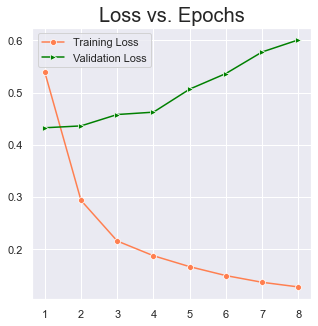

17/17 [==============================] - 0s 12ms/step - loss: 0.5066 - accuracy: 0.8296
Testing Accuracy:  82.9587996006012

Train dataset shape: (12799, 44093), 
Test dataset shape: (534, 44093)

Features Train dataset shape: (12799, 15000), 
FeaturesTest dataset shape: (534, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.77528, saving model to models\binary_classfiier\dl\merged_descr\model_6.h5

Epoch 00002: val_accuracy improved from 0.77528 to 0.78839, saving model to models\binary_classfiier\dl\merged_descr\model_6.h5

Epoch 00003: val_accuracy improved from 0.78839 to 0.82772, saving model to models\binary_classfiier\dl\merged_descr\model_6.h5

Epoch 00004: val_accuracy did not improve from 0.82772

Epoch 00005: val_accuracy did not improve from 0.82772

Epoch 00006: val_accuracy did not improve from 0.82772

Epoch 00007: val_accuracy did not improve from 0.82772

Epoch 00008: val_accuracy did not improve from 0.82772

Epoch 00009: val_accuracy did not improve from 0.8

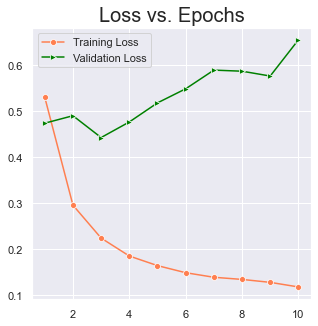

17/17 [==============================] - 0s 13ms/step - loss: 0.4425 - accuracy: 0.8277
Testing Accuracy:  82.77153372764587

Train dataset shape: (12799, 44158), 
Test dataset shape: (534, 44158)

Features Train dataset shape: (12799, 15000), 
FeaturesTest dataset shape: (534, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.79775, saving model to models\binary_classfiier\dl\merged_descr\model_7.h5

Epoch 00002: val_accuracy improved from 0.79775 to 0.81648, saving model to models\binary_classfiier\dl\merged_descr\model_7.h5

Epoch 00003: val_accuracy improved from 0.81648 to 0.82397, saving model to models\binary_classfiier\dl\merged_descr\model_7.h5

Epoch 00004: val_accuracy did not improve from 0.82397

Epoch 00005: val_accuracy did not improve from 0.82397

Epoch 00006: val_accuracy improved from 0.82397 to 0.82772, saving model to models\binary_classfiier\dl\merged_descr\model_7.h5

Epoch 00007: val_accuracy did not improve from 0.82772

Epoch 00008: val_accuracy did no

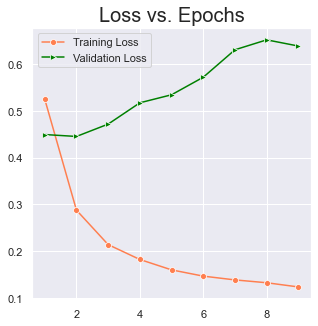

17/17 [==============================] - 0s 13ms/step - loss: 0.5724 - accuracy: 0.8277
Testing Accuracy:  82.77153372764587

Train dataset shape: (12799, 44069), 
Test dataset shape: (534, 44069)

Features Train dataset shape: (12799, 15000), 
FeaturesTest dataset shape: (534, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.79401, saving model to models\binary_classfiier\dl\merged_descr\model_8.h5

Epoch 00002: val_accuracy did not improve from 0.79401

Epoch 00003: val_accuracy improved from 0.79401 to 0.80524, saving model to models\binary_classfiier\dl\merged_descr\model_8.h5

Epoch 00004: val_accuracy did not improve from 0.80524

Epoch 00005: val_accuracy did not improve from 0.80524

Epoch 00006: val_accuracy improved from 0.80524 to 0.82772, saving model to models\binary_classfiier\dl\merged_descr\model_8.h5

Epoch 00007: val_accuracy did not improve from 0.82772

Epoch 00008: val_accuracy did not improve from 0.82772


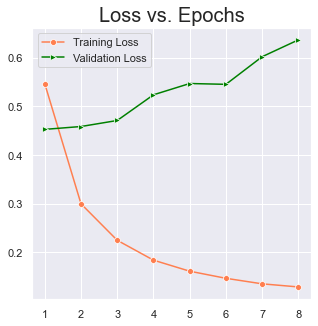

17/17 [==============================] - 0s 13ms/step - loss: 0.5452 - accuracy: 0.8277
Testing Accuracy:  82.77153372764587

Train dataset shape: (12800, 42822), 
Test dataset shape: (533, 42822)

Features Train dataset shape: (12800, 15000), 
FeaturesTest dataset shape: (533, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.81801, saving model to models\binary_classfiier\dl\merged_descr\model_9.h5

Epoch 00002: val_accuracy improved from 0.81801 to 0.83677, saving model to models\binary_classfiier\dl\merged_descr\model_9.h5

Epoch 00003: val_accuracy improved from 0.83677 to 0.84053, saving model to models\binary_classfiier\dl\merged_descr\model_9.h5

Epoch 00004: val_accuracy did not improve from 0.84053

Epoch 00005: val_accuracy improved from 0.84053 to 0.85553, saving model to models\binary_classfiier\dl\merged_descr\model_9.h5

Epoch 00006: val_accuracy did not improve from 0.85553

Epoch 00007: val_accuracy did not improve from 0.85553

Epoch 00008: val_accuracy did no

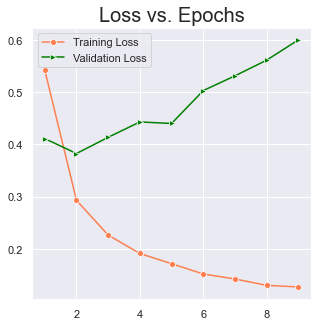

17/17 [==============================] - 0s 12ms/step - loss: 0.4401 - accuracy: 0.8555
Testing Accuracy:  85.55347323417664

Train dataset shape: (12800, 42839), 
Test dataset shape: (533, 42839)

Features Train dataset shape: (12800, 15000), 
FeaturesTest dataset shape: (533, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.89118, saving model to models\binary_classfiier\dl\merged_descr\model_10.h5

Epoch 00002: val_accuracy improved from 0.89118 to 0.90807, saving model to models\binary_classfiier\dl\merged_descr\model_10.h5

Epoch 00003: val_accuracy improved from 0.90807 to 0.91745, saving model to models\binary_classfiier\dl\merged_descr\model_10.h5

Epoch 00004: val_accuracy did not improve from 0.91745

Epoch 00005: val_accuracy did not improve from 0.91745

Epoch 00006: val_accuracy did not improve from 0.91745

Epoch 00007: val_accuracy did not improve from 0.91745

Epoch 00008: val_accuracy did not improve from 0.91745

Epoch 00009: val_accuracy did not improve from

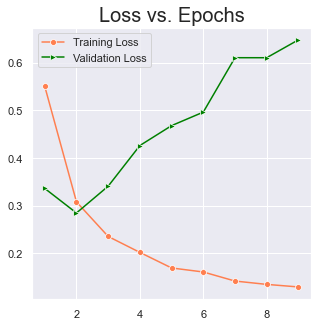

17/17 [==============================] - 0s 13ms/step - loss: 0.3410 - accuracy: 0.9174
Testing Accuracy:  91.74484014511108

Train dataset shape: (12800, 42812), 
Test dataset shape: (533, 42812)

Features Train dataset shape: (12800, 15000), 
FeaturesTest dataset shape: (533, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.91370, saving model to models\binary_classfiier\dl\merged_descr\model_11.h5

Epoch 00002: val_accuracy did not improve from 0.91370

Epoch 00003: val_accuracy improved from 0.91370 to 0.91557, saving model to models\binary_classfiier\dl\merged_descr\model_11.h5

Epoch 00004: val_accuracy improved from 0.91557 to 0.91745, saving model to models\binary_classfiier\dl\merged_descr\model_11.h5

Epoch 00005: val_accuracy improved from 0.91745 to 0.92308, saving model to models\binary_classfiier\dl\merged_descr\model_11.h5

Epoch 00006: val_accuracy did not improve from 0.92308

Epoch 00007: val_accuracy improved from 0.92308 to 0.92871, saving model to models\b

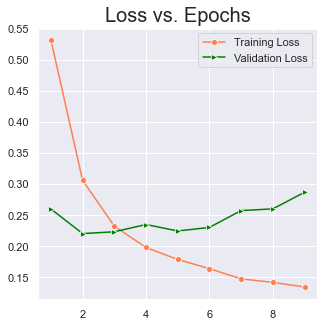

17/17 [==============================] - 0s 13ms/step - loss: 0.2596 - accuracy: 0.9306
Testing Accuracy:  93.05816292762756

Train dataset shape: (12800, 42924), 
Test dataset shape: (533, 42924)

Features Train dataset shape: (12800, 15000), 
FeaturesTest dataset shape: (533, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.90244, saving model to models\binary_classfiier\dl\merged_descr\model_12.h5

Epoch 00002: val_accuracy improved from 0.90244 to 0.91557, saving model to models\binary_classfiier\dl\merged_descr\model_12.h5

Epoch 00003: val_accuracy did not improve from 0.91557

Epoch 00004: val_accuracy did not improve from 0.91557

Epoch 00005: val_accuracy did not improve from 0.91557

Epoch 00006: val_accuracy did not improve from 0.91557

Epoch 00007: val_accuracy did not improve from 0.91557

Epoch 00008: val_accuracy did not improve from 0.91557

Epoch 00009: val_accuracy did not improve from 0.91557

Epoch 00010: val_accuracy improved from 0.91557 to 0.91745, savi

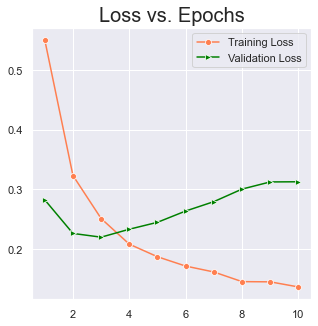

17/17 [==============================] - 0s 12ms/step - loss: 0.3127 - accuracy: 0.9174
Testing Accuracy:  91.74484014511108

Train dataset shape: (12800, 42352), 
Test dataset shape: (533, 42352)

Features Train dataset shape: (12800, 15000), 
FeaturesTest dataset shape: (533, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.91370, saving model to models\binary_classfiier\dl\merged_descr\model_13.h5

Epoch 00002: val_accuracy did not improve from 0.91370

Epoch 00003: val_accuracy improved from 0.91370 to 0.91557, saving model to models\binary_classfiier\dl\merged_descr\model_13.h5

Epoch 00004: val_accuracy improved from 0.91557 to 0.91932, saving model to models\binary_classfiier\dl\merged_descr\model_13.h5

Epoch 00005: val_accuracy did not improve from 0.91932

Epoch 00006: val_accuracy did not improve from 0.91932

Epoch 00007: val_accuracy did not improve from 0.91932

Epoch 00008: val_accuracy did not improve from 0.91932

Epoch 00009: val_accuracy did not improve from

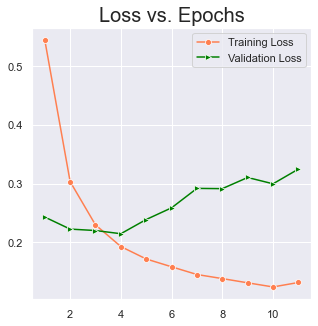

17/17 [==============================] - 0s 12ms/step - loss: 0.2147 - accuracy: 0.9193
Testing Accuracy:  91.93245768547058

Train dataset shape: (12800, 42877), 
Test dataset shape: (533, 42877)

Features Train dataset shape: (12800, 15000), 
FeaturesTest dataset shape: (533, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.91932, saving model to models\binary_classfiier\dl\merged_descr\model_14.h5

Epoch 00002: val_accuracy did not improve from 0.91932

Epoch 00003: val_accuracy improved from 0.91932 to 0.93246, saving model to models\binary_classfiier\dl\merged_descr\model_14.h5

Epoch 00004: val_accuracy did not improve from 0.93246

Epoch 00005: val_accuracy did not improve from 0.93246

Epoch 00006: val_accuracy did not improve from 0.93246

Epoch 00007: val_accuracy did not improve from 0.93246

Epoch 00008: val_accuracy did not improve from 0.93246

Epoch 00009: val_accuracy did not improve from 0.93246


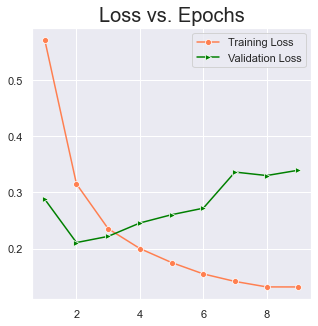

17/17 [==============================] - 0s 12ms/step - loss: 0.2220 - accuracy: 0.9325
Testing Accuracy:  93.24578046798706

Train dataset shape: (12800, 42637), 
Test dataset shape: (533, 42637)

Features Train dataset shape: (12800, 15000), 
FeaturesTest dataset shape: (533, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.91370, saving model to models\binary_classfiier\dl\merged_descr\model_15.h5

Epoch 00002: val_accuracy improved from 0.91370 to 0.91932, saving model to models\binary_classfiier\dl\merged_descr\model_15.h5

Epoch 00003: val_accuracy improved from 0.91932 to 0.93433, saving model to models\binary_classfiier\dl\merged_descr\model_15.h5

Epoch 00004: val_accuracy did not improve from 0.93433

Epoch 00005: val_accuracy did not improve from 0.93433

Epoch 00006: val_accuracy did not improve from 0.93433

Epoch 00007: val_accuracy did not improve from 0.93433

Epoch 00008: val_accuracy did not improve from 0.93433

Epoch 00009: val_accuracy did not improve from

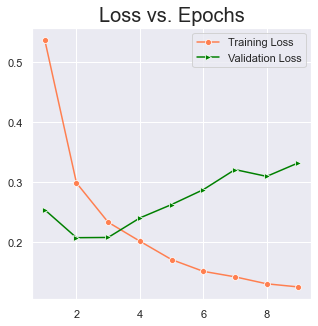

17/17 [==============================] - 0s 12ms/step - loss: 0.2073 - accuracy: 0.9343
Testing Accuracy:  93.43339800834656

Train dataset shape: (12800, 42434), 
Test dataset shape: (533, 42434)

Features Train dataset shape: (12800, 15000), 
FeaturesTest dataset shape: (533, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.90619, saving model to models\binary_classfiier\dl\merged_descr\model_16.h5

Epoch 00002: val_accuracy improved from 0.90619 to 0.91182, saving model to models\binary_classfiier\dl\merged_descr\model_16.h5

Epoch 00003: val_accuracy did not improve from 0.91182

Epoch 00004: val_accuracy improved from 0.91182 to 0.91745, saving model to models\binary_classfiier\dl\merged_descr\model_16.h5

Epoch 00005: val_accuracy improved from 0.91745 to 0.92120, saving model to models\binary_classfiier\dl\merged_descr\model_16.h5

Epoch 00006: val_accuracy did not improve from 0.92120

Epoch 00007: val_accuracy improved from 0.92120 to 0.92308, saving model to models\b

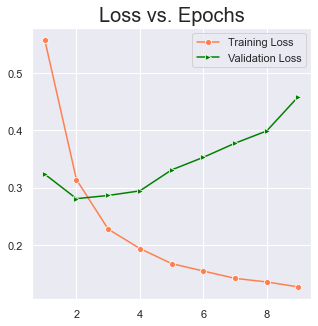

17/17 [==============================] - 0s 13ms/step - loss: 0.3774 - accuracy: 0.9231
Testing Accuracy:  92.30769276618958

Train dataset shape: (12800, 42548), 
Test dataset shape: (533, 42548)

Features Train dataset shape: (12800, 15000), 
FeaturesTest dataset shape: (533, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.88743, saving model to models\binary_classfiier\dl\merged_descr\model_17.h5

Epoch 00002: val_accuracy improved from 0.88743 to 0.89493, saving model to models\binary_classfiier\dl\merged_descr\model_17.h5

Epoch 00003: val_accuracy improved from 0.89493 to 0.92683, saving model to models\binary_classfiier\dl\merged_descr\model_17.h5

Epoch 00004: val_accuracy did not improve from 0.92683

Epoch 00005: val_accuracy did not improve from 0.92683

Epoch 00006: val_accuracy did not improve from 0.92683

Epoch 00007: val_accuracy did not improve from 0.92683

Epoch 00008: val_accuracy did not improve from 0.92683

Epoch 00009: val_accuracy did not improve from

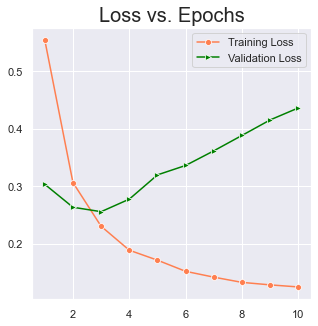

17/17 [==============================] - 0s 13ms/step - loss: 0.4362 - accuracy: 0.9287
Testing Accuracy:  92.87054538726807

Train dataset shape: (12800, 42844), 
Test dataset shape: (533, 42844)

Features Train dataset shape: (12800, 15000), 
FeaturesTest dataset shape: (533, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.91370, saving model to models\binary_classfiier\dl\merged_descr\model_18.h5

Epoch 00002: val_accuracy did not improve from 0.91370

Epoch 00003: val_accuracy did not improve from 0.91370

Epoch 00004: val_accuracy did not improve from 0.91370

Epoch 00005: val_accuracy did not improve from 0.91370

Epoch 00006: val_accuracy did not improve from 0.91370

Epoch 00007: val_accuracy did not improve from 0.91370

Epoch 00008: val_accuracy did not improve from 0.91370

Epoch 00009: val_accuracy did not improve from 0.91370


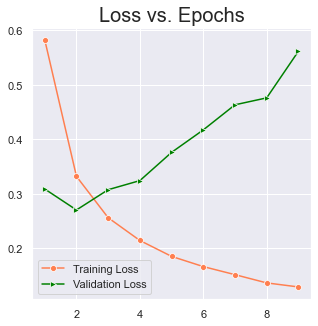

17/17 [==============================] - 0s 13ms/step - loss: 0.3091 - accuracy: 0.9137
Testing Accuracy:  91.36960506439209

Train dataset shape: (12800, 42796), 
Test dataset shape: (533, 42796)

Features Train dataset shape: (12800, 15000), 
FeaturesTest dataset shape: (533, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.88743, saving model to models\binary_classfiier\dl\merged_descr\model_19.h5

Epoch 00002: val_accuracy did not improve from 0.88743

Epoch 00003: val_accuracy improved from 0.88743 to 0.90056, saving model to models\binary_classfiier\dl\merged_descr\model_19.h5

Epoch 00004: val_accuracy did not improve from 0.90056

Epoch 00005: val_accuracy improved from 0.90056 to 0.90244, saving model to models\binary_classfiier\dl\merged_descr\model_19.h5

Epoch 00006: val_accuracy improved from 0.90244 to 0.90807, saving model to models\binary_classfiier\dl\merged_descr\model_19.h5

Epoch 00007: val_accuracy did not improve from 0.90807

Epoch 00008: val_accuracy di

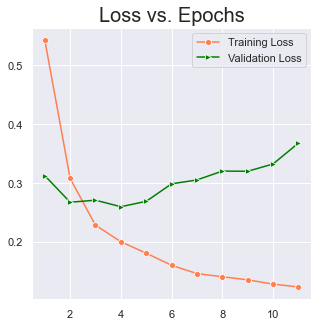

17/17 [==============================] - 0s 12ms/step - loss: 0.3320 - accuracy: 0.9250
Testing Accuracy:  92.49531030654907

Train dataset shape: (12800, 43092), 
Test dataset shape: (533, 43092)

Features Train dataset shape: (12800, 15000), 
FeaturesTest dataset shape: (533, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.91745, saving model to models\binary_classfiier\dl\merged_descr\model_20.h5

Epoch 00002: val_accuracy improved from 0.91745 to 0.93246, saving model to models\binary_classfiier\dl\merged_descr\model_20.h5

Epoch 00003: val_accuracy improved from 0.93246 to 0.94747, saving model to models\binary_classfiier\dl\merged_descr\model_20.h5

Epoch 00004: val_accuracy did not improve from 0.94747

Epoch 00005: val_accuracy improved from 0.94747 to 0.94934, saving model to models\binary_classfiier\dl\merged_descr\model_20.h5

Epoch 00006: val_accuracy did not improve from 0.94934

Epoch 00007: val_accuracy did not improve from 0.94934

Epoch 00008: val_accuracy di

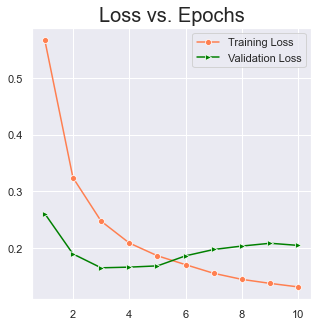

17/17 [==============================] - 0s 13ms/step - loss: 0.2046 - accuracy: 0.9512
Testing Accuracy:  95.12194991111755

Train dataset shape: (12800, 43195), 
Test dataset shape: (533, 43195)

Features Train dataset shape: (12800, 15000), 
FeaturesTest dataset shape: (533, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.89306, saving model to models\binary_classfiier\dl\merged_descr\model_21.h5

Epoch 00002: val_accuracy improved from 0.89306 to 0.90807, saving model to models\binary_classfiier\dl\merged_descr\model_21.h5

Epoch 00003: val_accuracy improved from 0.90807 to 0.92120, saving model to models\binary_classfiier\dl\merged_descr\model_21.h5

Epoch 00004: val_accuracy improved from 0.92120 to 0.92683, saving model to models\binary_classfiier\dl\merged_descr\model_21.h5

Epoch 00005: val_accuracy did not improve from 0.92683

Epoch 00006: val_accuracy did not improve from 0.92683

Epoch 00007: val_accuracy did not improve from 0.92683

Epoch 00008: val_accuracy di

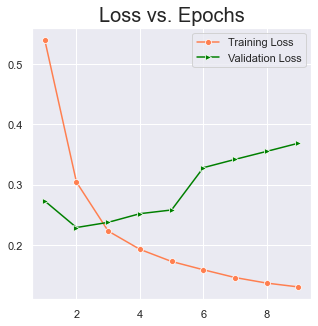

17/17 [==============================] - 0s 12ms/step - loss: 0.2519 - accuracy: 0.9268
Testing Accuracy:  92.68292784690857

Train dataset shape: (12800, 42431), 
Test dataset shape: (533, 42431)

Features Train dataset shape: (12800, 15000), 
FeaturesTest dataset shape: (533, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.90432, saving model to models\binary_classfiier\dl\merged_descr\model_22.h5

Epoch 00002: val_accuracy improved from 0.90432 to 0.90994, saving model to models\binary_classfiier\dl\merged_descr\model_22.h5

Epoch 00003: val_accuracy improved from 0.90994 to 0.91370, saving model to models\binary_classfiier\dl\merged_descr\model_22.h5

Epoch 00004: val_accuracy improved from 0.91370 to 0.92120, saving model to models\binary_classfiier\dl\merged_descr\model_22.h5

Epoch 00005: val_accuracy did not improve from 0.92120

Epoch 00006: val_accuracy did not improve from 0.92120

Epoch 00007: val_accuracy improved from 0.92120 to 0.93246, saving model to models\b

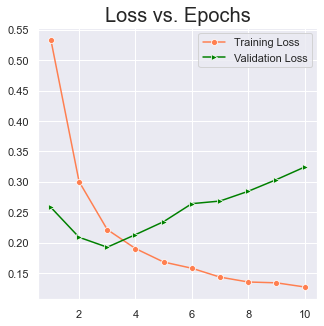

17/17 [==============================] - 0s 12ms/step - loss: 0.2683 - accuracy: 0.9325
Testing Accuracy:  93.24578046798706

Train dataset shape: (12800, 42684), 
Test dataset shape: (533, 42684)

Features Train dataset shape: (12800, 15000), 
FeaturesTest dataset shape: (533, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.92871, saving model to models\binary_classfiier\dl\merged_descr\model_23.h5

Epoch 00002: val_accuracy improved from 0.92871 to 0.93621, saving model to models\binary_classfiier\dl\merged_descr\model_23.h5

Epoch 00003: val_accuracy did not improve from 0.93621

Epoch 00004: val_accuracy did not improve from 0.93621

Epoch 00005: val_accuracy did not improve from 0.93621

Epoch 00006: val_accuracy did not improve from 0.93621

Epoch 00007: val_accuracy did not improve from 0.93621

Epoch 00008: val_accuracy improved from 0.93621 to 0.93996, saving model to models\binary_classfiier\dl\merged_descr\model_23.h5

Epoch 00009: val_accuracy did not improve from

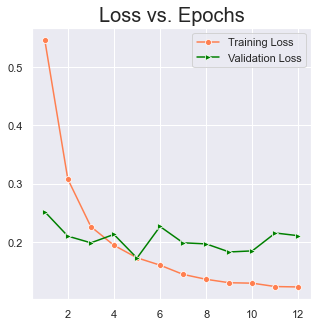

17/17 [==============================] - 0s 11ms/step - loss: 0.2111 - accuracy: 0.9437
Testing Accuracy:  94.37147974967957

Train dataset shape: (12800, 41631), 
Test dataset shape: (533, 41631)

Features Train dataset shape: (12800, 15000), 
FeaturesTest dataset shape: (533, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.88555, saving model to models\binary_classfiier\dl\merged_descr\model_24.h5

Epoch 00002: val_accuracy improved from 0.88555 to 0.91745, saving model to models\binary_classfiier\dl\merged_descr\model_24.h5

Epoch 00003: val_accuracy did not improve from 0.91745

Epoch 00004: val_accuracy did not improve from 0.91745

Epoch 00005: val_accuracy improved from 0.91745 to 0.92120, saving model to models\binary_classfiier\dl\merged_descr\model_24.h5

Epoch 00006: val_accuracy improved from 0.92120 to 0.93058, saving model to models\binary_classfiier\dl\merged_descr\model_24.h5

Epoch 00007: val_accuracy did not improve from 0.93058

Epoch 00008: val_accuracy di

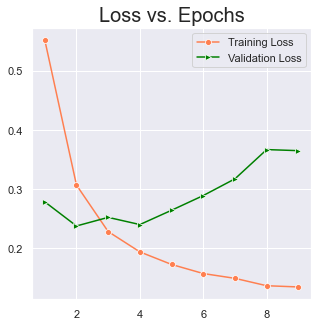

17/17 [==============================] - 0s 11ms/step - loss: 0.2892 - accuracy: 0.9306
Testing Accuracy:  93.05816292762756

Train dataset shape: (12800, 42691), 
Test dataset shape: (533, 42691)

Features Train dataset shape: (12800, 15000), 
FeaturesTest dataset shape: (533, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.92683, saving model to models\binary_classfiier\dl\merged_descr\model_25.h5

Epoch 00002: val_accuracy improved from 0.92683 to 0.93246, saving model to models\binary_classfiier\dl\merged_descr\model_25.h5

Epoch 00003: val_accuracy improved from 0.93246 to 0.93621, saving model to models\binary_classfiier\dl\merged_descr\model_25.h5

Epoch 00004: val_accuracy did not improve from 0.93621

Epoch 00005: val_accuracy did not improve from 0.93621

Epoch 00006: val_accuracy did not improve from 0.93621

Epoch 00007: val_accuracy did not improve from 0.93621

Epoch 00008: val_accuracy did not improve from 0.93621

Epoch 00009: val_accuracy did not improve from

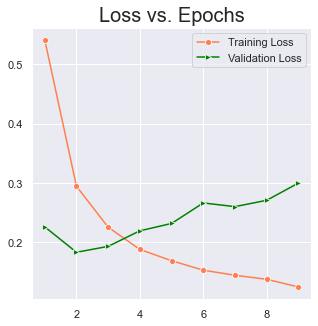

17/17 [==============================] - 0s 12ms/step - loss: 0.1934 - accuracy: 0.9362
Testing Accuracy:  93.62101554870605


In [67]:
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_extraction.text import TfidfVectorizer


def get_model_name(k):
    return f'model_{k}.h5'

NUM_SPLITS = 25
EPOCHS = 15
save_dir = Path('./models/binary_classfiier/dl/merged_descr')
fold_var = 1
NGRAM_RANGE = (1, 2)
TOP_K = 15000
TOKEN_MODE = 'word'
MIN_DOC_FREQ = 2
NUM_CLASSES = 2

kwargs = {
        'ngram_range' : NGRAM_RANGE,
        'dtype' : 'int32',
        'strip_accents' : 'unicode',
        'decode_error' : 'replace',
        'analyzer' : TOKEN_MODE,
        'min_df' : MIN_DOC_FREQ
    }

val_accs = []
skf = StratifiedKFold(n_splits=NUM_SPLITS, shuffle=False, random_state=seed)

for train_indices, test_indices in skf.split(X, y):
    X_train_split, X_test_split = X[train_indices], X[test_indices]
    y_train_split, y_test_split = y[train_indices], y[test_indices]
    vectorizer = TfidfVectorizer(**kwargs)
    X_train_vec = vectorizer.fit_transform(X_train_split)
    X_test_vec = vectorizer.transform(X_test_split)
    print(f"\nTrain dataset shape: {X_train_vec.shape}, \nTest dataset shape: {X_test_vec.shape}")

    selector = SelectKBest(f_classif, k=min(TOP_K, X_train_vec.shape[1]))
    selector.fit(X_train_vec, y_train_split)
    X_train_vec = selector.transform(X_train_vec).astype('float32')
    X_test_vec = selector.transform(X_test_vec).astype('float32')
    X_train_vec = X_train_vec.toarray()
    X_test_vec = X_test_vec.toarray()

    print(f"\nFeatures Train dataset shape: {X_train_vec.shape}, \nFeaturesTest dataset shape: {X_test_vec.shape}")
    model_ = None
    model_ = Sequential([   
        Dense(30, activation='relu', input_shape=X_train_vec.shape[1:]),
        Dropout(0.5),
        Dense(20, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model_.compile(
        loss = 'binary_crossentropy',
        optimizer = 'adam',
        metrics = ['accuracy']
    )
    
    checkpoint = tensorflow.keras.callbacks.ModelCheckpoint(save_dir / get_model_name(fold_var),
                                                            monitor='val_accuracy',
                                                            verbose=1,
                                                            save_best_only=True,
                                                            mode='max')

    h_ = model_.fit(
            X_train_vec, y_train_split,
            validation_data = (X_test_vec, y_test_split),  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [checkpoint, early_stop],
            verbose = False)
    
    model_.load_weights(save_dir / get_model_name(fold_var))
    plot_learning_curve(h_)
    loss, acc = model_.evaluate(X_test_vec, y_test_split)
    print("Testing Accuracy: ", acc*100)
    val_accs.append(acc)
    tensorflow.keras.backend.clear_session()
    fold_var += 1

In [68]:
print("Testing Accuracy: ", np.mean(val_accs)*100)   # average k fold accuracy

Testing Accuracy:  89.3012626171112
